In [1]:
%load_ext lineapy
%load_ext autoreload
%autoreload 2


In [2]:
import duckdb
import polars as pl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from scipy import signal
import mlflow
from rcssim import rcs_sim as rcs
import plotly.express as px
from typing import Tuple
import vegafusion as vf
from joypy import joyplot
import lineapy


In [3]:
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import cross_validate


In [4]:
alt.data_transformers.disable_max_rows()
dataspell = False
use_data_server = False # Use data server if you want to use the Vega Editor window
use_browser_for_plotly=False

# The below commands allow for Altair to plot large data sets.

if dataspell:
    if use_data_server:
        alt.data_transformers.enable('data_server') # <- Exports to temporary localHost URL
        print('Data Server Enabled')
    else:
        vf.enable()
        print('VegaFusion Enabled')
    if use_browser_for_plotly:
        import plotly.io as pio
        pio.renderers.default = 'browser'
    print("DataSpell Setup")
else:
    # DO NOT RUN BELOW IN REMOTE VSCODE.
    if use_data_server:
        alt.data_transformers.enable('data_server') # <- Exports to temporary localHost URL
    else:
        vf.enable_widget(data_dir='/media/shortterm_ssd/Clay/altairdata/')
    if use_browser_for_plotly:
        import plotly.io as pio
        pio.renderers.default = 'browser'

    from plotly_resampler import register_plotly_resampler, unregister_plotly_resampler
    register_plotly_resampler(mode='auto')
    print("VS Code: VegaFusion Widget and plotly resampler")


VS Code: VegaFusion Widget and plotly resampler


In [5]:
# Test if altair displays
tmp_df = pd.DataFrame({'A': np.arange(50), 'B': np.arange(50,100)})
alt.Chart(tmp_df).mark_point().encode(
    x='A:Q',
    y='B:Q',
).interactive()

VegaFusionWidget(spec='{\n  "config": {\n    "view": {\n      "continuousWidth": 400,\n      "continuousHeight…

In [6]:
# Test if plotly displays
px.box(pd.DataFrame({'A': np.arange(50), 'B': np.arange(50,100)}).melt(value_vars=['A', 'B']), x='variable', y='value')

FigureWidgetResampler({
    'data': [{'alignmentgroup': 'True',
              'hovertemplate': 'variable=%{x}<…

# Extract relevant data

In [8]:
# TODO: Put this into script so can be accessed as a module


In [14]:
con = duckdb.connect(database='/media/shortterm_ssd/Clay/databases/duckdb/rcs-db.duckdb', read_only=True)

In [7]:
def get_device_as_pl_df(device, db_con):
    """
    Accesses duckdb database and returns columns of interest, labeled reasonably with session identifiers cast as categoricals.
    :param device: device name (str) (e.g. '02L')
    :param db_con: duckdb connection object
    :return: polars Dataframe
    """
    db_con.sql("SET TIMEZONE = 'America/Los_Angeles'")
    return db_con.sql(f"select DerivedTime, columns('localTime'), columns('^Session|TD_|Power_Band'), SleepStage from overnight.r{device}").pl().with_columns(
        pl.col('^Session.*$').cast(pl.Categorical)
    )  # .with_columns(pl.col('localTime').dt.convert_time_zone('America/Los_Angeles'))


In [8]:
def get_device_as_pd_df(device, db_con):
    """
    Accesses duckdb database and returns columns of interest, labeled reasonably with session identifiers cast as categoricals.
    :param device: device name (str) (e.g. '02L')
    :param db_con: duckdb connection object
    :return: polars Dataframe
    """
    return db_con.execute(f"select DerivedTime, columns('localTime'), columns('^Session|TD_|Power_Band'), SleepStage from overnight.r{device}").df()


# RCS_SIM Functions

In [9]:
def rcssim_wrapper(td_data, times, settings, gain) -> Tuple[np.ndarray, int]:
    """
    This function takes in polars lists of times (DerivedTimes) and timedomain data (td_data), and returns an estimate of the embedded RCS fft vector.
    params:
    times: (pl.list of floats: unix timestamps) 1xn vector of DerivedTimes
    td_data: (pl.list of floats: millivolts) 1xn vector of time domain data
    settings: (dict) settings for device
    returns: data_fft_pl: (pl.list of floats) Estimate of embedded FFT vector(s) (size: mxn) corresponding to td_data
             t_pb: (float: unix timestamp) DerivedTime unix timestamp of FFT vector
    """
    hann_win = rcs.create_hann_window(settings['fft_size'][0], percent=100)
    # times_np = times.to_numpy(zero_copy_only=True)

    # td_np = rcs.transform_mv_to_rcs(td_data.to_numpy(zero_copy_only=True), gain)
    td_np = rcs.transform_mv_to_rcs(td_data, gain)

    data_fft, t_pb = rcs.td_to_fft(td_np, times,
                                   settings['samplingRate'][0],
                                   settings['fft_size'][0], settings['fft_interval'][0],
                                   hann_win, interp_drops=False, output_in_mv=False, shift_timestamps_up_by_one_ind=True)
    data_fft_out = rcs.fft_to_pb(data_fft, settings['samplingRate'][0], settings['fft_size'][0],
                                 settings['fft_bandFormationConfig'][0],
                                 input_is_mv=False)
    return data_fft_out, t_pb


In [10]:
def get_gains_from_settings_dict(settings, sessions, identity_col, device, db_con) -> np.ndarray:
    """

    :param settings:
    :param sessions:
    :param identity_col:
    :param device:
    :param db_con:
    :return:
    """
    td_settings = db_con.execute(f"Select columns('^chan'), columns('^gain') from r{device}.TDSettings where {identity_col} in {*sessions,}").df().drop_duplicates()
    if len(td_settings) > 1:
        print(f"WARNING: MULTIPLE TIME DOMAIN SETTINGS FOUND for {device} sessions {sessions}. Using the first unique values.")
    gains = []
    for i in range(1,len(td_settings.columns)+1):
        if (f"chan{i}" in td_settings.columns) and not ('Disabled' in td_settings[f"chan{i}"][0]):
            gains.append(td_settings[f"gain_{i}"][0])
    return np.array(gains)


In [11]:
def get_settings_for_pb_calcs(device, db_con, session_nums, identity_col):
    """
    Get the relevant settings to run rcs_sim package functions:
        rcs.create_hann_window
        rcs.transform_mv_to_rcs
        rcs.td_to_fft
        rcs.fft_to_pb

    :param device:
    :param db_con:
    :param session_nums: list of SessionIdentity values to pull settings from
    :return:
    """
    # TODO: FIX THIS FUNCTION TO ALLOW FOR identity_col = 'Session#'

    td_settings = db_con.execute(f"Select {identity_col}, samplingRate, columns('^gain') from r{device}.TDSettings where {identity_col} in {*session_nums,}").df()
    fft_settings = db_con.execute(f"Select {identity_col}, fft_bandFormationConfig, fft_interval, fft_size, fft_windowLoad, fft_numBins, fft_binWidth, columns('^Power_Band') from r{device}.FftAndPowerSettings where SessionIdentity in {*session_nums,}").df()
    settings_df = pd.concat([td_settings, fft_settings], axis=1, join='inner')
    settings_df['fft_bandFormationConfig'] = settings_df['fft_bandFormationConfig'].str.extract('(\d+)').astype(int)
    if not (np.sum(np.unique(settings_df.loc[:, settings_df.columns!=identity_col].nunique().values)) == 1):
        print("WARNING: Session numbers provided have different settings.")
        print('Settings dataframe:')
        print(settings_df)

    return settings_df.loc[:, settings_df.columns!=identity_col].drop_duplicates().to_dict('list')

 ## Create FFT vectors

## FFT vectors to PBs

# Feature Selection Functions

# Classification Functions

## Classification

## Classification Scoring

# Visualization functions

# Execution Cells

In [14]:
df = get_device_as_pl_df('02L', con)


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

In [15]:
df.select('Session#').unique()


Session#
cat
"""Session1650952..."
"""Session1651816..."
"""Session1651562..."
"""Session1651734..."
"""Session1650607..."
"""Session1651304..."
"""Session1650521..."
"""Session1651206..."
"""Session1651124..."


In [16]:
df.head()


DerivedTime,localTime,TD_BG,TD_key2,TD_key3,Power_Band1,Power_Band2,Power_Band5,Power_Band6,Power_Band7,Power_Band8,Session#,SessionIdentity,SleepStage
f64,"datetime[μs, America/Los_Angeles]",f64,f64,f64,f64,f64,f64,f64,f64,f64,cat,cat,f64
1.6510e12,2022-04-25 22:49:52.979 PDT,-0.265827,0.015227,0.0842,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0
1.6510e12,2022-04-25 22:49:52.981 PDT,0.210623,-0.016847,0.033114,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0
1.6510e12,2022-04-25 22:49:52.983 PDT,0.281445,0.143844,0.181362,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0
1.6510e12,2022-04-25 22:49:52.985 PDT,-0.203356,0.1419,0.192037,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0
1.6510e12,2022-04-25 22:49:52.987 PDT,-0.206068,0.006048,0.064158,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0


In [17]:
df_grouped = df.groupby_dynamic('localTime', every='1s', period='2s', by=['SessionIdentity', 'SleepStage']).agg([
    pl.col('DerivedTime'),
    pl.col('^Power_Band.*$').drop_nulls().first(),
    pl.col('TD_BG'),
    pl.col('TD_key2'),
    pl.col('TD_key3'),
    pl.col('TD_BG').count().alias('TD_count')]).select(pl.all().shrink_dtype())


In [18]:
df_grouped = df_grouped.with_columns(
    pl.col('TD_BG').arr.eval(pl.element().is_null().any()).alias('TD_null')
).filter((pl.col('TD_count') == 1000) &
         (pl.col('TD_null').arr.contains(False))
         )


In [19]:
df_grouped.head()


SessionIdentity,SleepStage,localTime,DerivedTime,Power_Band1,Power_Band2,Power_Band5,Power_Band6,Power_Band7,Power_Band8,TD_BG,TD_key2,TD_key3,TD_count,TD_null
cat,f32,"datetime[μs, America/Los_Angeles]",list[f64],f32,f32,f32,f32,f32,f32,list[f64],list[f64],list[f64],u16,list[bool]
"""02L_04-26-22""",6.0,2022-04-25 22:49:53 PDT,"[1.6510e12, 1.6510e12, ... 1.6510e12]",95016.0,373.0,1.010882e6,2532.0,1132.0,226.0,"[-0.286109, -0.042732, ... -0.324936]","[0.097624, -0.029806, ... -0.157559]","[0.14912, 0.031371, ... -0.037144]",1000,[false]
"""02L_04-26-22""",6.0,2022-04-25 22:49:54 PDT,"[1.6510e12, 1.6510e12, ... 1.6510e12]",95016.0,373.0,1.010882e6,2532.0,1132.0,226.0,"[-0.201079, 0.262465, ... 0.064749]","[-0.266198, -0.242872, ... -0.237581]","[-0.086923, -0.08213, ... -0.08115]",1000,[false]
"""02L_04-26-22""",6.0,2022-04-25 22:49:55 PDT,"[1.6510e12, 1.6510e12, ... 1.6510e12]",906.0,370.0,2340.0,3341.0,432.0,147.0,"[0.157913, 0.161926, ... 0.252596]","[-0.185313, -0.033801, ... -0.128618]","[-0.076902, 0.066445, ... 0.01623]",1000,[false]
"""02L_04-26-22""",6.0,2022-04-25 22:49:56 PDT,"[1.6510e12, 1.6510e12, ... 1.6510e12]",882.0,482.0,1009.0,836.0,225.0,88.0,"[0.213551, -0.260188, ... -0.07516]","[-0.113823, -0.094816, ... -0.016307]","[0.038669, 0.073416, ... 0.113501]",1000,[false]
"""02L_04-26-22""",6.0,2022-04-25 22:49:57 PDT,"[1.6510e12, 1.6510e12, ... 1.6510e12]",577.0,288.0,990.0,1836.0,112.0,137.0,"[-0.152382, -0.396301, ... -0.411919]","[-0.060475, -0.166306, ... -0.074838]","[0.088339, -0.013507, ... 0.051522]",1000,[false]


In [20]:
device = '02L'
sessions = df_grouped.select('SessionIdentity').unique().to_dict(as_series=False)['SessionIdentity']
settings = get_settings_for_pb_calcs(device, con, sessions, 'SessionIdentity')
print(settings)
gains = get_gains_from_settings_dict(settings, sessions, 'SessionIdentity', device, con)
print(gains)


{'samplingRate': [500], 'gain_1': [232], 'gain_2': [231], 'gain_3': [233], 'gain_4': [231], 'fft_bandFormationConfig': [3], 'fft_interval': [1000], 'fft_size': [1024], 'fft_windowLoad': ['100% Hann'], 'fft_numBins': [512], 'fft_binWidth': [0.48828125], 'Power_Band1': ['0.73-4.15'], 'Power_Band2': ['4.15-12.45'], 'Power_Band3': ['132.08-134.03'], 'Power_Band4': ['128.17-129.64'], 'Power_Band5': ['0.73-4.15'], 'Power_Band6': ['4.64-12.45'], 'Power_Band7': ['17.82-30.03'], 'Power_Band8': ['39.79-63.23'], 'Power_Band1_indices': ['3  9'], 'Power_Band2_indices': ['10  26'], 'Power_Band3_indices': ['272  275'], 'Power_Band4_indices': ['264  266'], 'Power_Band5_indices': ['3  9'], 'Power_Band6_indices': ['11  26'], 'Power_Band7_indices': ['38  62'], 'Power_Band8_indices': ['83  130'], 'Power_Band1_bins': ['0.98-3.91'], 'Power_Band2_bins': ['4.39-12.21'], 'Power_Band3_bins': ['132.32-133.79'], 'Power_Band4_bins': ['128.42-129.39'], 'Power_Band5_bins': ['0.98-3.91'], 'Power_Band6_bins': ['4.88-1

### Backfill method of windowing

In [21]:
df_pb_count = df.join(
    df.filter(pl.col('Power_Band8').is_not_null()).select(
        'DerivedTime').with_row_count(),
    on='DerivedTime', how='left').with_columns(pl.col('row_nr').fill_null(strategy='backward')).rename({'row_nr': 'PB_count'})


In [22]:
df_pb_count


DerivedTime,localTime,TD_BG,TD_key2,TD_key3,Power_Band1,Power_Band2,Power_Band5,Power_Band6,Power_Band7,Power_Band8,Session#,SessionIdentity,SleepStage,PB_count
f64,"datetime[μs, America/Los_Angeles]",f64,f64,f64,f64,f64,f64,f64,f64,f64,cat,cat,f64,u32
1.6510e12,2022-04-25 22:49:52.979 PDT,-0.265827,0.015227,0.0842,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0
1.6510e12,2022-04-25 22:49:52.981 PDT,0.210623,-0.016847,0.033114,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0
1.6510e12,2022-04-25 22:49:52.983 PDT,0.281445,0.143844,0.181362,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0
1.6510e12,2022-04-25 22:49:52.985 PDT,-0.203356,0.1419,0.192037,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0
1.6510e12,2022-04-25 22:49:52.987 PDT,-0.206068,0.006048,0.064158,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0
1.6510e12,2022-04-25 22:49:52.989 PDT,0.274721,0.012203,0.048472,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0
1.6510e12,2022-04-25 22:49:52.991 PDT,0.226783,0.174514,0.207831,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0
1.6510e12,2022-04-25 22:49:52.993 PDT,-0.255741,0.120086,0.175044,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0
1.6510e12,2022-04-25 22:49:52.995 PDT,-0.125918,-0.010691,0.046403,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0


In [23]:
df_pb_count = df_pb_count.with_columns([
    pl.when( (pl.col('PB_count') % 2) == 0).then(pl.lit(None)).otherwise(pl.col('PB_count')).fill_null(strategy='backward').alias('PB_count_odd'),
    pl.when( (pl.col('PB_count') % 2) == 1).then(pl.lit(None)).otherwise(pl.col('PB_count')).fill_null(strategy='backward').alias('PB_count_even')
])


In [24]:
df_pb_count


DerivedTime,localTime,TD_BG,TD_key2,TD_key3,Power_Band1,Power_Band2,Power_Band5,Power_Band6,Power_Band7,Power_Band8,Session#,SessionIdentity,SleepStage,PB_count,PB_count_odd,PB_count_even
f64,"datetime[μs, America/Los_Angeles]",f64,f64,f64,f64,f64,f64,f64,f64,f64,cat,cat,f64,u32,u32,u32
1.6510e12,2022-04-25 22:49:52.979 PDT,-0.265827,0.015227,0.0842,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0,1,0
1.6510e12,2022-04-25 22:49:52.981 PDT,0.210623,-0.016847,0.033114,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0,1,0
1.6510e12,2022-04-25 22:49:52.983 PDT,0.281445,0.143844,0.181362,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0,1,0
1.6510e12,2022-04-25 22:49:52.985 PDT,-0.203356,0.1419,0.192037,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0,1,0
1.6510e12,2022-04-25 22:49:52.987 PDT,-0.206068,0.006048,0.064158,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0,1,0
1.6510e12,2022-04-25 22:49:52.989 PDT,0.274721,0.012203,0.048472,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0,1,0
1.6510e12,2022-04-25 22:49:52.991 PDT,0.226783,0.174514,0.207831,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0,1,0
1.6510e12,2022-04-25 22:49:52.993 PDT,-0.255741,0.120086,0.175044,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0,1,0
1.6510e12,2022-04-25 22:49:52.995 PDT,-0.125918,-0.010691,0.046403,null,null,null,null,null,null,"""Session1650952...","""02L_04-26-22""",6.0,0,1,0


In [25]:
df_pb_count = df_pb_count.groupby(['SleepStage', 'PB_count_even']).agg(
    [
        pl.col('DerivedTime'),
        pl.col('^Power_Band.*$').drop_nulls().first(),
        pl.col('TD_BG'),
        pl.col('TD_key2'),
        pl.col('TD_key3'),
        pl.col('TD_BG').count().alias('TD_count')
    ]).rename({'PB_count_even': 'PB_ind'}).vstack(
        df_pb_count.groupby(['SleepStage', 'PB_count_odd']).agg(
            [
                pl.col('DerivedTime'),
                pl.col('^Power_Band.*$').drop_nulls().first(),
                pl.col('TD_BG'),
                pl.col('TD_key2'),
                pl.col('TD_key3'),
                pl.col('TD_BG').count().alias('TD_count')
            ]).rename({'PB_count_odd': 'PB_ind'})
).select(pl.all().shrink_dtype()).rechunk()


In [26]:
df_pb_count.head()


SleepStage,PB_ind,DerivedTime,Power_Band1,Power_Band2,Power_Band5,Power_Band6,Power_Band7,Power_Band8,TD_BG,TD_key2,TD_key3,TD_count
f32,u32,list[f64],f32,f32,f32,f32,f32,f32,list[f64],list[f64],list[f64],u32
3.0,4714,"[1.6518e12, 1.6518e12, ... 1.6518e12]",447.0,1529.0,2861.0,33699.0,578.0,32.0,"[-0.09349, 0.135896, ... 0.086006]","[-0.117818, -0.195788, ... -0.159611]","[0.017646, -0.076357, ... 0.01013]",1000
3.0,6762,"[1.6518e12, 1.6518e12, ... 1.6518e12]",559.0,547.0,2328.0,8479.0,343.0,86.0,"[-0.065833, 0.172772, ... 0.132859]","[-0.149136, -0.02959, ... -0.09244]","[-0.050106, 0.068188, ... 0.001416]",1000
2.0,8810,"[1.6518e12, 1.6518e12, ... 1.6518e12]",496.0,195.0,1765.0,14511.0,520.0,96.0,"[-0.28394, 0.061603, ... -0.088826]","[-0.160367, -0.065659, ... -0.085313]","[-0.038342, 0.050651, ... 0.013507]",1000
2.0,10858,"[1.6518e12, 1.6518e12, ... 1.6518e12]",317.0,467.0,14198.0,7509.0,303.0,65.0,"[-0.285675, -0.052168, ... -0.182533]","[-0.060583, -0.100108, ... -0.100756]","[0.056206, 0.015685, ... 0.030281]",1000
6.0,12906,"[1.6518e12, 1.6518e12, ... 1.6518e12]",1182.0,711.0,4830.0,8301.0,204.0,207.0,"[0.147176, -0.001301, ... 0.11594]","[-0.21879, -0.205831, ... -0.16879]","[-0.081586, -0.082566, ... -0.106966]",1000


In [27]:
df_pb_count.select(
    pl.col('DerivedTime').arr.diff()
).select(
    pl.col('DerivedTime').arr.unique()
).with_columns(
    pl.col('DerivedTime').arr.to_struct()
).unnest('DerivedTime').unique()


field_0,field_1
f64,f64
null,2.0
null,null


______________________________________________________________

## Feature selection playground... what the hell do I make of the output of RCS sim

In [28]:
td_np = df_grouped.select([
    pl.col('DerivedTime'),
    pl.col('TD_BG'),
    pl.col('TD_key2'),
    pl.col('TD_key3')
]).to_numpy()


In [29]:
fft_arr_BG = np.zeros((td_np.shape[0], settings['fft_numBins'][0]))
fft_arr_2 = np.zeros((td_np.shape[0], settings['fft_numBins'][0]))
fft_arr_3 = np.zeros((td_np.shape[0], settings['fft_numBins'][0]))


for i in range(td_np.shape[0]):
    fft_arr_BG[i], dtime = rcssim_wrapper(td_np[i,1], td_np[i,0], settings, gains[0])
    fft_arr_2[i], dtime = rcssim_wrapper(td_np[i,2],td_np[i,0],  settings, gains[1])
    fft_arr_3[i], dtime = rcssim_wrapper(td_np[i,3],td_np[i,0],  settings, gains[2])

In [30]:

df_grouped = df_grouped.hstack(
    pl.DataFrame({'fft_BG': fft_arr_BG,
                  'fft_key2': fft_arr_2,
                  'fft_key3': fft_arr_3})
)


In [31]:
df_grouped.head()


SessionIdentity,SleepStage,localTime,DerivedTime,Power_Band1,Power_Band2,Power_Band5,Power_Band6,Power_Band7,Power_Band8,TD_BG,TD_key2,TD_key3,TD_count,TD_null,fft_BG,fft_key2,fft_key3
cat,f32,"datetime[μs, America/Los_Angeles]",list[f64],f32,f32,f32,f32,f32,f32,list[f64],list[f64],list[f64],u16,list[bool],list[f64],list[f64],list[f64]
"""02L_04-26-22""",6.0,2022-04-25 22:49:53 PDT,"[1.6510e12, 1.6510e12, ... 1.6510e12]",95016.0,373.0,1.010882e6,2532.0,1132.0,226.0,"[-0.286109, -0.042732, ... -0.324936]","[0.097624, -0.029806, ... -0.157559]","[0.14912, 0.031371, ... -0.037144]",1000,[false],"[7380.0, 24034.0, ... 0.0]","[1.511793e6, 430727.0, ... 0.0]","[56788.0, 21848.0, ... 0.0]"
"""02L_04-26-22""",6.0,2022-04-25 22:49:54 PDT,"[1.6510e12, 1.6510e12, ... 1.6510e12]",95016.0,373.0,1.010882e6,2532.0,1132.0,226.0,"[-0.201079, 0.262465, ... 0.064749]","[-0.266198, -0.242872, ... -0.237581]","[-0.086923, -0.08213, ... -0.08115]",1000,[false],"[187320.0, 54650.0, ... 0.0]","[720774.0, 183087.0, ... 0.0]","[104.0, 1692.0, ... 0.0]"
"""02L_04-26-22""",6.0,2022-04-25 22:49:55 PDT,"[1.6510e12, 1.6510e12, ... 1.6510e12]",906.0,370.0,2340.0,3341.0,432.0,147.0,"[0.157913, 0.161926, ... 0.252596]","[-0.185313, -0.033801, ... -0.128618]","[-0.076902, 0.066445, ... 0.01623]",1000,[false],"[265722.0, 67485.0, ... 0.0]","[572576.0, 149246.0, ... 0.0]","[5817.0, 1660.0, ... 0.0]"
"""02L_04-26-22""",6.0,2022-04-25 22:49:56 PDT,"[1.6510e12, 1.6510e12, ... 1.6510e12]",882.0,482.0,1009.0,836.0,225.0,88.0,"[0.213551, -0.260188, ... -0.07516]","[-0.113823, -0.094816, ... -0.016307]","[0.038669, 0.073416, ... 0.113501]",1000,[false],"[300371.0, 77033.0, ... 0.0]","[533238.0, 142489.0, ... 0.0]","[14607.0, 4604.0, ... 0.0]"
"""02L_04-26-22""",6.0,2022-04-25 22:49:57 PDT,"[1.6510e12, 1.6510e12, ... 1.6510e12]",577.0,288.0,990.0,1836.0,112.0,137.0,"[-0.152382, -0.396301, ... -0.411919]","[-0.060475, -0.166306, ... -0.074838]","[0.088339, -0.013507, ... 0.051522]",1000,[false],"[377546.0, 117316.0, ... 0.0]","[506823.0, 139894.0, ... 0.0]","[14874.0, 3143.0, ... 0.0]"


In [32]:
df_grouped.height


213661

## Plotting playground

In [33]:
# import os
# from toolz.curried import pipe


# def json_dir(data, data_dir='/media/shortterm_ssd/Clay/altairdata'):
#     os.makedirs(data_dir, exist_ok=True)
#     return pipe(data, alt.to_json(filename=data_dir + '/{prefix}-{hash}.{extension}', urlpath='files') )


# alt.data_transformers.register('json_dir', json_dir)
# alt.data_transformers.enable('json_dir')
# alt.data_transformers.enable('json')
# alt.data_transformers.disable_max_rows()
# vf.enable()


In [34]:
# def to_json_for_lab(data):
#     output = alt.to_json(data)
#     output['url'] = os.path.join("/media/shortterm_ssd/Clay/altairdata/", output["url"])
#     return output

# alt.data_transformers.register('json', to_json_for_lab)
# alt.data_transformers.enable('json')
# alt.data_transformers.enable('default')


In [35]:
# Note: below still saves JSON in local directory
# alt.data_transformers.enable('json', urlpath='/media/shortterm_ssd/Clay/altairdata/')


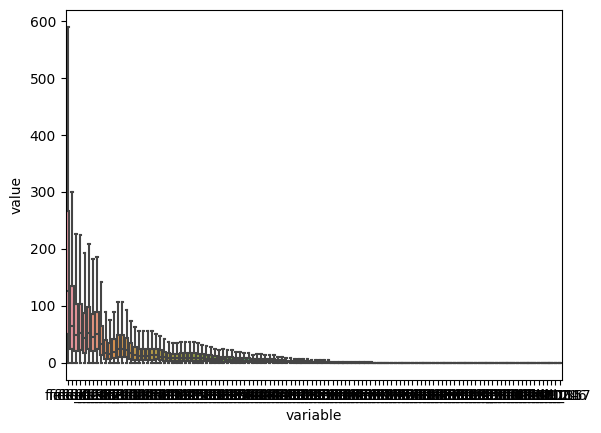

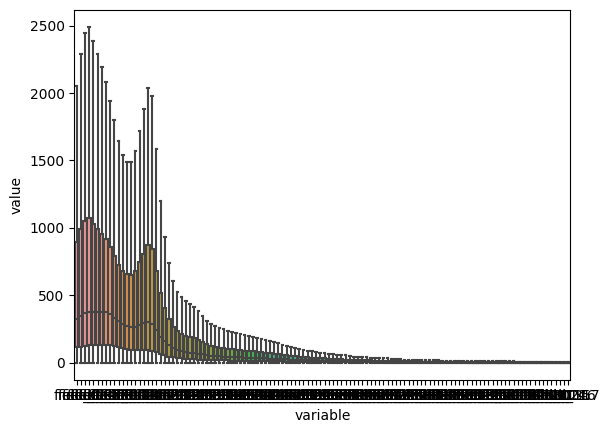

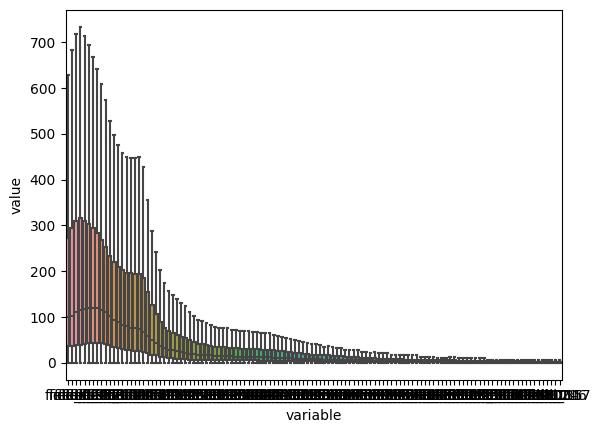

In [26]:
# Expand FFT list into columns, then plot in long-form with Altair
start = 2
length = 118

for i in ['BG', 'key2', 'key3']:
    df_pd = (df_grouped.select([
        pl.col('fft_' + i).arr.slice(start, length).arr.to_struct()
    ]
    ).unnest('fft_' + i)
        .melt(
        value_vars=pl.select(pl.col(('^field.*$')))
    )
    ).to_pandas()

    sns.boxplot(data=df_pd, x='variable', y='value', orient='v', showfliers=False)
    plt.show()
    # Something seems odd at the higher powerbands, all 0 with no variance?.. verify with embedded calculation with both DF grouping methods


In [27]:
# alt.Chart(df_pd).mark_boxplot().encode(x='variable:N', y='value:Q')


In [36]:
# Expand FFT list into columns, then plot in long-form with Altair
start = 2
length = 118


df_fft_vec = (df_grouped.with_columns([
    pl.col('^fft_.*$').arr.slice(start, length)
])
.with_columns(
    pl.col('fft_BG').arr.concat([pl.col('fft_key2'), pl.col('fft_key3')]).arr.to_struct().alias('fft_vec')
)
.unnest('fft_vec')
)
# .select([pl.col('SleepStage'), pl.col('^field_.*$')])
# .melt(
#     id_vars='SleepStage',
#     value_vars=pl.select(pl.col(('^field_.*$')))
#     )
# )

In [37]:
df_fft_vec.head()


SessionIdentity,SleepStage,localTime,DerivedTime,Power_Band1,Power_Band2,Power_Band5,Power_Band6,Power_Band7,Power_Band8,TD_BG,TD_key2,TD_key3,TD_count,TD_null,fft_BG,fft_key2,fft_key3,field_0,field_1,field_2,field_3,field_4,field_5,field_6,field_7,field_8,field_9,field_10,field_11,field_12,field_13,field_14,field_15,field_16,field_17,field_18,...,field_317,field_318,field_319,field_320,field_321,field_322,field_323,field_324,field_325,field_326,field_327,field_328,field_329,field_330,field_331,field_332,field_333,field_334,field_335,field_336,field_337,field_338,field_339,field_340,field_341,field_342,field_343,field_344,field_345,field_346,field_347,field_348,field_349,field_350,field_351,field_352,field_353
cat,f32,"datetime[μs, America/Los_Angeles]",list[f64],f32,f32,f32,f32,f32,f32,list[f64],list[f64],list[f64],u16,list[bool],list[f64],list[f64],list[f64],f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,...,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
"""02L_04-26-22""",6.0,2022-04-25 22:49:53 PDT,"[1.6510e12, 1.6510e12, ... 1.6510e12]",95016.0,373.0,1.010882e6,2532.0,1132.0,226.0,"[-0.286109, -0.042732, ... -0.324936]","[0.097624, -0.029806, ... -0.157559]","[0.14912, 0.031371, ... -0.037144]",1000,[false],"[2461.0, 192.0, ... 0.0]","[4073.0, 200.0, ... 7.0]","[2244.0, 206.0, ... 0.0]",2461.0,192.0,11.0,136.0,22.0,20.0,32.0,11.0,65.0,36.0,44.0,35.0,2.0,34.0,1.0,27.0,29.0,3.0,16.0,...,4.0,12.0,2.0,4.0,3.0,1.0,3.0,7.0,7.0,0.0,2.0,2.0,17.0,17.0,4.0,1.0,1.0,4.0,4.0,4.0,6.0,4.0,6.0,8.0,10.0,3.0,1.0,1.0,0.0,1.0,0.0,0.0,3.0,3.0,1.0,2.0,0.0
"""02L_04-26-22""",6.0,2022-04-25 22:49:54 PDT,"[1.6510e12, 1.6510e12, ... 1.6510e12]",95016.0,373.0,1.010882e6,2532.0,1132.0,226.0,"[-0.201079, 0.262465, ... 0.064749]","[-0.266198, -0.242872, ... -0.237581]","[-0.086923, -0.08213, ... -0.08115]",1000,[false],"[180.0, 102.0, ... 0.0]","[222.0, 280.0, ... 1.0]","[301.0, 14.0, ... 1.0]",180.0,102.0,8.0,74.0,5.0,101.0,107.0,37.0,81.0,31.0,21.0,13.0,34.0,63.0,31.0,30.0,8.0,10.0,5.0,...,1.0,0.0,6.0,3.0,0.0,1.0,3.0,12.0,15.0,14.0,6.0,5.0,6.0,3.0,0.0,1.0,1.0,0.0,2.0,5.0,3.0,1.0,1.0,5.0,5.0,4.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0
"""02L_04-26-22""",6.0,2022-04-25 22:49:55 PDT,"[1.6510e12, 1.6510e12, ... 1.6510e12]",906.0,370.0,2340.0,3341.0,432.0,147.0,"[0.157913, 0.161926, ... 0.252596]","[-0.185313, -0.033801, ... -0.128618]","[-0.076902, 0.066445, ... 0.01623]",1000,[false],"[150.0, 153.0, ... 0.0]","[254.0, 342.0, ... 10.0]","[2.0, 18.0, ... 2.0]",150.0,153.0,39.0,95.0,12.0,32.0,14.0,23.0,85.0,42.0,17.0,19.0,12.0,18.0,9.0,25.0,31.0,10.0,10.0,...,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,8.0,4.0,1.0,2.0,0.0,6.0,7.0,0.0,2.0,4.0,1.0,1.0,0.0,4.0,10.0,9.0,6.0,1.0,4.0,5.0,0.0,2.0,1.0,0.0,2.0
"""02L_04-26-22""",6.0,2022-04-25 22:49:56 PDT,"[1.6510e12, 1.6510e12, ... 1.6510e12]",882.0,482.0,1009.0,836.0,225.0,88.0,"[0.213551, -0.260188, ... -0.07516]","[-0.113823, -0.094816, ... -0.016307]","[0.038669, 0.073416, ... 0.113501]",1000,[false],"[9.0, 58.0, ... 0.0]","[645.0, 557.0, ... 0.0]","[88.0, 92.0, ... 0.0]",9.0,58.0,37.0,52.0,36.0,64.0,42.0,33.0,84.0,22.0,1.0,4.0,38.0,32.0,5.0,54.0,49.0,4.0,10.0,...,1.0,2.0,9.0,3.0,0.0,0.0,1.0,1.0,0.0,3.0,8.0,9.0,5.0,0.0,0.0,0.0,4.0,2.0,0.0,2.0,4.0,6.0,5.0,0.0,5.0,5.0,0.0,0.0,1.0,0.0,2.0,1.0,7.0,7.0,4.0,2.0,0.0
"""02L_04-26-22""",6.0,2022-04-25 22:49:57 PDT,"[1.6510e12, 1.6510e12, ... 1.6510e12]",577.0,288.0,990.0,1836.0,112.0,137.0,"[-0.152382, -0.396301, ... -0.411919]","[-0.060475, -0.166306, ... -0.074838]","[0.088339, -0.013507, ... 0.051522]",1000,[false],"[2391.0, 569.0, ... 0.0]","[1268.0, 480.0, ... 1.0]","[127.0, 22.0, ... 1.0]",2391.0,569.0,226.0,78.0,9.0,32.0,76.0,37.0,128.0,48.0,9.0,36.0,8.0,58.0,37.0,7.0,15.0,10.0,47.0,...,0.0,5.0,1.0,7.0,5.0,1.0,2.0,2.0,1.0,1.0,13.0,16.0,13.0,13.0,10.0,2.0,1.0,5.0,4.0,1.0,2.0,1.0,2.0,3.0,0.0,1.0,2.0,2.0,0.0,3.0,1.0,3.0,5.0,3.0

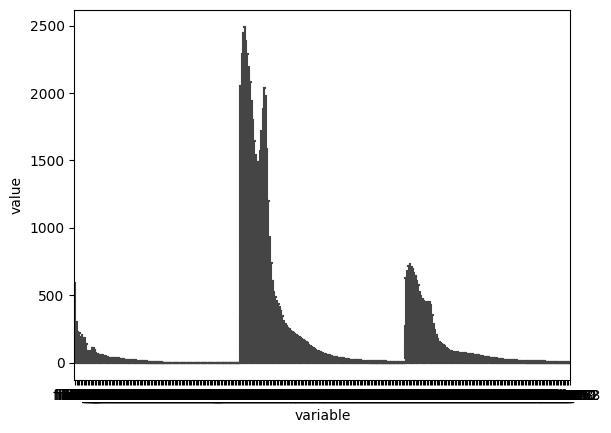

In [30]:
sns.boxplot(
    data=df_fft_vec.to_pandas(),
    x='variable', y='value', orient='v', showfliers=False)
plt.show()


## Model Pipeline Development


In [56]:
# Expand FFT list into columns, then plot in long-form with Altair
start = 2
vec_length = 118

df_fft_vec = (df_grouped.with_columns([
    pl.col('^fft_.*$').arr.slice(start, vec_length)
])
    .with_columns(
    pl.col('fft_BG').arr.concat([pl.col('fft_key2'), pl.col(
        'fft_key3')]).arr.to_struct().alias('fft_vec')
)
    .unnest('fft_vec')
    .with_columns([
        pl.col('SleepStage').map_dict(
            {2: 2, 3: 1, 4: 0, 5: -1, 6: -2}).alias('SleepStageAsc'),
        pl.col('SleepStage').map_dict(
            {2: 1, 3: 1, 4: 0, 5: 0, 6: 0}).alias('SleepStageBinary')
    ])
)


In [61]:
df_fft_vec.select(['SleepStageAsc', 'SleepStageBinary']).describe()


describe,SleepStageAsc,SleepStageBinary
str,f64,f64
"""count""",213661.0,213661.0
"""null_count""",0.0,0.0
"""mean""",0.186047,0.579582
"""std""",1.372425,0.493627
"""min""",-2.0,0.0
"""max""",2.0,1.0
"""median""",1.0,1.0


In [70]:
px.line(df_fft_vec.select([
    pl.pearson_corr(f"field_{i}", pl.col('SleepStageAsc').cast(pl.Float64)).alias(f"field_{i}_corr") for i in range(vec_length*3)
]).to_numpy().squeeze())


FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=0<br>index=%{x}<br>value=%{y}<extra></extra>'…

In [59]:

px.line(df_fft_vec.select([
    pl.pearson_corr(f"field_{i}", pl.col('SleepStageBinary').cast(pl.Float64)).alias(f"field_{i}_corr") for i in range(vec_length*3)
]).to_numpy().squeeze())


FigureWidgetResampler({
    'data': [{'hovertemplate': 'variable=0<br>index=%{x}<br>value=%{y}<extra></extra>'…

In [42]:
# Hyperparameters
shift = np.arange(0, 8)
update_rates = np.arange(1, 61)


PIPELINE (each step will be an aggregate of functions)

  1. Collect Patient Data
  2. Transform into TD Windows
  For Shift value
  3. Collect FFTs via RCS_SIM package
  4. COLLECT PBs

Additionally,
  1. Split FFT vectors into sections based on correlation (or mutual information) values, magnitude needs to be above threshold
  1. Create Grid of hyperparameters
  2. Train and cross validate each of the below models on data collected above\
    *LDA\
    *2-step LDA\
    *Decision Tree

Be careful to keep track of how data was partitioned in cross-validation, so that models can easily be recreated.

Save Grid and Classification Scores in pl Dataframe, and export to parquet or DuckDB (or both)

After the best hyperparameters have been identified, use ALL data to train a final model for production.


In [22]:
a = (pl.DataFrame(np.array(np.meshgrid(np.arange(60), np.arange(60))).T.reshape(-1, 2)).rename({"column_0": 'pb1_start', 'column_1': 'pb1_end'})
     .filter(
    (pl.col('pb1_start') < pl.col('pb1_end'))
    &
    ((pl.col('pb1_end') - pl.col('pb1_start')) > 1)
))

b = (pl.DataFrame(np.array(np.meshgrid(np.arange(60, 120), np.arange(60, 120))).T.reshape(-1, 2)).rename({"column_0": 'pb2_start', 'column_1': 'pb2_end'})
     .filter((pl.col('pb2_start') < pl.col('pb2_end'))))


In [26]:
a[400:600]


pb1_start,pb1_end
i64,i64
7,24
7,25
7,26
7,27
7,28
7,29
7,30
7,31
7,32


In [24]:
crossjoin = a.join(b, how='cross')


In [25]:
f"{crossjoin.height ** 2:,}"


'9,171,630,540,900'

In [8]:
chan1_sim = crossjoin.filter( (
    ((pl.col('pb2_start') >= pl.col('pb1_start')) & (pl.col('pb2_end') <= pl.col('pb1_end')))
).is_not()).filter((
    ((pl.col('pb1_start') >= pl.col('pb2_start')) & (pl.col('pb1_end') <= pl.col('pb2_end')))
).is_not())


In [9]:
chan1_sim


pb1_start,pb1_end,pb2_start,pb2_end
i64,i64,i64,i64
0,1,60,61
0,1,60,62
0,1,60,63
0,1,60,64
0,1,60,65
0,1,60,66
0,1,60,67
0,1,60,68
0,1,60,69


In [16]:
sleep_stage_mapping = {2: 1, 3: 1, 4: 0, 5: 0, 6: 0}


In [ ]:

device = '02L'
df = get_device_as_pl_df(device, con)
sessions = df_grouped.select('SessionIdentity').unique().to_dict(
    as_series=False)['SessionIdentity']
gains = get_gains_from_settings_dict(
    settings, sessions, 'SessionIdentity', device, con)
print(gains)

align_with_PB_outputs = False

if align_with_PB_outputs:
    df_pb_count = df.join(
        df.filter(pl.col('Power_Band8').is_not_null()).select(
            'DerivedTime').with_row_count(),
        on='DerivedTime', how='left').with_columns(pl.col('row_nr').fill_null(strategy='backward')).rename({'row_nr': 'PB_count'})

    df_pb_count = df_pb_count.with_columns([
        pl.when( (pl.col('PB_count') % 2) == 0).then(pl.lit(None)).otherwise(pl.col('PB_count')).fill_null(strategy='backward').alias('PB_count_odd'),
        pl.when( (pl.col('PB_count') % 2) == 1).then(pl.lit(None)).otherwise(pl.col('PB_count')).fill_null(strategy='backward').alias('PB_count_even')
    ])

    df_pb_count = df_pb_count.groupby(['SleepStage', 'PB_count_even']).agg(
        [
            pl.col('DerivedTime'),
            pl.col('^Power_Band.*$').drop_nulls().first(),
            pl.col('TD_BG'),
            pl.col('TD_key2'),
            pl.col('TD_key3'),
            pl.col('TD_BG').count().alias('TD_count')
        ]).rename({'PB_count_even': 'PB_ind'}).vstack(
            df_pb_count.groupby(['SleepStage', 'PB_count_odd']).agg(
                [
                    pl.col('DerivedTime'),
                    pl.col('^Power_Band.*$').drop_nulls().first(),
                    pl.col('TD_BG'),
                    pl.col('TD_key2'),
                    pl.col('TD_key3'),
                    pl.col('TD_BG').count().alias('TD_count')
                ]).rename({'PB_count_odd': 'PB_ind'})
    ).select(pl.all().shrink_dtype()).rechunk()

    df_chunked = df_pb_count
else:
    df_grouped = df.groupby_dynamic('localTime', every='1s', period='2s', by=['SessionIdentity', 'SleepStage']).agg([
        pl.col('DerivedTime'),
        pl.col('^Power_Band.*$').drop_nulls().first(),
        pl.col('TD_BG'),
        pl.col('TD_key2'),
        pl.col('TD_key3'),
        pl.col('TD_BG').count().alias('TD_count')]).select(pl.all().shrink_dtype())

    df_grouped = df_grouped.with_columns(
                pl.col('TD_BG').arr.eval(pl.element().is_null().any()).alias('TD_null')
            ).filter((pl.col('TD_count') == 1000) &
                    (pl.col('TD_null').arr.contains(False))
                    )
    df_chunked = df_grouped


In [15]:
td_np = df_chunked.select([
    pl.col('DerivedTime'),
    pl.col('TD_BG'),
    pl.col('TD_key2'),
    pl.col('TD_key3')
]).to_numpy()

fft_arr_BG = np.zeros((td_np.shape[0], settings['fft_numBins'][0]))
fft_arr_2 = np.zeros((td_np.shape[0], settings['fft_numBins'][0]))
fft_arr_3 = np.zeros((td_np.shape[0], settings['fft_numBins'][0]))

fft_ind_start = 2
vec_length = 118

for shift in np.arange(8):
    sim_settings = settings.copy()
    sim_settings['fft_bandFormationConfig'] = [shift]
    for i in range(td_np.shape[0]):
        fft_arr_BG[i], dtime = rcssim_wrapper(td_np[i,1], td_np[i,0], sim_settings, gains[0])
        fft_arr_2[i], dtime = rcssim_wrapper(td_np[i,2],td_np[i,0],  sim_settings, gains[1])
        fft_arr_3[i], dtime = rcssim_wrapper(td_np[i,3],td_np[i,0],  sim_settings, gains[2])

    df_chunked = df_chunked.hstack(
    pl.DataFrame({'fft_BG': fft_arr_BG,
                    'fft_key2': fft_arr_2,
                    'fft_key3': fft_arr_3})
    )

    df_fft_vec = (df_chunked.with_columns([
                        pl.col('^fft_.*$').arr.slice(fft_ind_start, vec_length)
                    ])
                    .with_columns(
                        pl.col('fft_BG').arr.concat([pl.col('fft_key2'), pl.col('fft_key3')]).arr.to_struct().alias('fft_vec')
                    )
                    .unnest('fft_vec')
                    .with_columns([
                        pl.col('SleepStage').map_dict({2: 1, 3: 1, 4: 0, 5: 0, 6: 0}).alias('SleepStageBinary') 
                    ])
                    )
    
    fft_corrs = df_fft_vec.select([
                        pl.pearson_corr(f"field_{i}", pl.col('SleepStageBinary').cast(pl.Float64)).alias(f"field_{i}_corr") for i in range(vec_length*3)
                    ]).to_numpy().squeeze()


NameError: name 'df_chunked' is not defined

In [16]:
from sklearn.metrics import confusion_matrix
def confusion_matrix_scorer(clf, X, y):
      y_pred = clf.predict(X)
      cm = confusion_matrix(y, y_pred, normalize='true')
      return {'tn': cm[0, 0], 'fp': cm[0, 1],
              'fn': cm[1, 0], 'tp': cm[1, 1]}

In [17]:
update_rates = [1, 5, 10, 15, 30]
devices = ['02L', '02R', '03L', '03R', '07L', '07R', '09L', '09R', '16L', '16R']
sleep_stage_mapping = {2: 1, 3: 1, 4: 0, 5: 0, 6: 0}
repeat_cv = False

for i, device in enumerate(devices):
   print(device)
   if repeat_cv:
      scores = []
      scores_var = []
   else:
      cv_results = {'test_tn': [], 'test_fp': [], 'test_fn': [], 'test_tp': []}
   df = get_device_as_pl_df(device, con)
   for update_rate in update_rates:
      data_for_baseline = (df.filter(pl.col('Power_Band8').is_not_null())
                           .with_row_count().with_columns([
                              pl.col('row_nr') // update_rate
                           ])
                           .groupby(['row_nr']).agg([
                              pl.col('Power_Band5').mean().alias('Power_Band5'),
                              pl.col('Power_Band6').mean().alias('Power_Band6'),
                              pl.col('Power_Band7').mean().alias('Power_Band7'),
                              pl.col('Power_Band8').mean().alias('Power_Band8'),
                              pl.col('SleepStage').last().alias('SleepStage')
                           ])
                           )


      # X = PB features
      X = data_for_baseline.select(pl.col('^Power_.*$')).to_numpy()
      # y = sleep stage labels
      y = data_for_baseline.select(
         pl.col('SleepStage').map_dict(sleep_stage_mapping)
      ).to_numpy().squeeze()
      # solver = {‘svd’, ‘lsqr’, ‘eigen’}
      model = LinearDiscriminantAnalysis(solver='svd')

      if repeat_cv:
         # define model evaluation method
         cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=3, random_state=1)
         # evaluate model
         scores_tmp = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=20)
         scores.append(np.mean(scores_tmp))
         scores_var.append(np.std(scores_tmp))
      else:
         cv_results_tmp = cross_validate(model, X, y, cv=5,
                      scoring=confusion_matrix_scorer)
         print(cv_results_tmp)
         [cv_results[k].extend([np.mean(v)]) for (k, v) in cv_results_tmp.items() if k in cv_results.keys()]
         
   if repeat_cv:
      if i == 0:
         df_scores = pd.DataFrame({'update_rate': update_rates, 'score': scores, 'score_std': scores_var, 'device': device})
      else:
         df_tmp = pd.DataFrame({'update_rate': update_rates, 'score': scores, 'score_std': scores_var, 'device': device})
         df_scores = pd.concat([df_scores, df_tmp])
   else:
      if i == 0:
         df_scores = pd.DataFrame({'update_rate': update_rates, **cv_results, 'device': device})
      else:
         df_tmp = pd.DataFrame({'update_rate': update_rates, **cv_results, 'device': device})
         df_scores = pd.concat([df_scores, df_tmp])

print(df_scores.head())


02L


FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

{'fit_time': array([0.10124588, 0.10604143, 0.13145542, 0.11871672, 0.11410165]), 'score_time': array([0.07062316, 0.06188059, 0.06923366, 0.06267715, 0.0462358 ]), 'test_tn': array([0.61843894, 0.60407941, 0.60533043, 0.60949739, 0.61063969]), 'test_fp': array([0.38156106, 0.39592059, 0.39466957, 0.39050261, 0.38936031]), 'test_fn': array([0.10850708, 0.10672078, 0.10234372, 0.10643801, 0.11021805]), 'test_tp': array([0.89149292, 0.89327922, 0.89765628, 0.89356199, 0.88978195])}
{'fit_time': array([0.03212857, 0.04001641, 0.03950334, 0.03971887, 0.04246092]), 'score_time': array([0.01437616, 0.00994825, 0.00592446, 0.00590897, 0.00593972]), 'test_tn': array([0.7888013 , 0.77058983, 0.77684153, 0.7800435 , 0.77650897]), 'test_fp': array([0.2111987 , 0.22941017, 0.22315847, 0.2199565 , 0.22349103]), 'test_fn': array([0.12179104, 0.11442786, 0.11544586, 0.119801  , 0.11004975]), 'test_tp': array([0.87820896, 0.88557214, 0.88455414, 0.880199  , 0.88995025])}
{'fit_time': array([0.01725554

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

{'fit_time': array([0.11624479, 0.1143508 , 0.12373948, 0.12650299, 0.12487674]), 'score_time': array([0.06686878, 0.02476597, 0.01972914, 0.02172709, 0.01850152]), 'test_tn': array([0.76835882, 0.76351021, 0.76546467, 0.76082283, 0.76272843]), 'test_fp': array([0.23164118, 0.23648979, 0.23453533, 0.23917717, 0.23727157]), 'test_fn': array([0.22621943, 0.22667918, 0.22970897, 0.22953828, 0.22609141]), 'test_tp': array([0.77378057, 0.77332082, 0.77029103, 0.77046172, 0.77390859])}
{'fit_time': array([0.03094697, 0.02626991, 0.02139306, 0.02096272, 0.0214932 ]), 'score_time': array([0.00557494, 0.004179  , 0.00920868, 0.00359607, 0.00353503]), 'test_tn': array([0.86590132, 0.87441974, 0.87564134, 0.87246518, 0.87246518]), 'test_fp': array([0.13409868, 0.12558026, 0.12435866, 0.12753482, 0.12753482]), 'test_fn': array([0.20892019, 0.19479411, 0.20759548, 0.21100917, 0.21079582]), 'test_tp': array([0.79107981, 0.80520589, 0.79240452, 0.78899083, 0.78920418])}
{'fit_time': array([0.01696324

FloatProgress(value=0.0, layout=Layout(width='100%'), style=ProgressStyle(bar_color='black'))

{'fit_time': array([0.07192993, 0.0964272 , 0.09533358, 0.11198235, 0.08771729]), 'score_time': array([0.01931024, 0.01236916, 0.01081491, 0.01051426, 0.01006031]), 'test_tn': array([0.84537237, 0.84665227, 0.8449724 , 0.84241261, 0.84313255]), 'test_fp': array([0.15462763, 0.15334773, 0.1550276 , 0.15758739, 0.15686745]), 'test_fn': array([0.32565641, 0.32738185, 0.31892865, 0.32568085, 0.32388026]), 'test_tp': array([0.67434359, 0.67261815, 0.68107135, 0.67431915, 0.67611974])}
{'fit_time': array([0.0155201 , 0.02418542, 0.02428722, 0.02521062, 0.02547717]), 'score_time': array([0.00527763, 0.00512218, 0.00521541, 0.00521326, 0.00523257]), 'test_tn': array([0.91406875, 0.91963215, 0.91963215, 0.91283487, 0.91443423]), 'test_fp': array([0.08593125, 0.08036785, 0.08036785, 0.08716513, 0.08556577]), 'test_fn': array([0.27354597, 0.28292683, 0.28667917, 0.27242026, 0.27767355]), 'test_tp': array([0.72645403, 0.71707317, 0.71332083, 0.72757974, 0.72232645])}
{'fit_time': array([0.00856733

In [18]:

px.line(df_scores, x='update_rate', y='score', error_y='score_std', color='device', labels={'x': 'Update rate', 'y': 'Accuracy'})


ValueError: Value of 'y' is not the name of a column in 'data_frame'. Expected one of ['update_rate', 'test_tn', 'test_fp', 'test_fn', 'test_tp', 'device'] but received: score

In [19]:
px.line(df_scores, x='update_rate', y='test_tp', color='device', labels={'x': 'Update rate', 'y': 'True Positive Rate'})


FigureWidgetResampler({
    'data': [{'hovertemplate': 'device=02L<br>update_rate=%{x}<br>test_tp=%{y}<extra><…

In [20]:
px.line(df_scores, x='update_rate', y='test_tn', color='device', labels={'x': 'Update rate', 'y': 'True Negative Rate'})

FigureWidgetResampler({
    'data': [{'hovertemplate': 'device=02L<br>update_rate=%{x}<br>test_tn=%{y}<extra><…

In [79]:
df_scores

,update_rate,test_tn,test_fp,test_fn,test_tp,device
0,1,0.610304,0.389696,0.106710,0.893290,02L
1,5,0.777579,0.222421,0.116662,0.883338,02L
2,10,0.820068,0.179932,0.112491,0.887509,02L
3,15,0.835153,0.164847,0.111946,0.888054,02L
4,30,0.848837,0.151163,0.105012,0.894988,02L
0,1,0.671915,0.328085,0.117915,0.882085,02R
1,5,0.824009,0.175991,0.147013,0.852987,02R
2,10,0.855276,0.144724,0.141638,0.858362,02R
3,15,0.862393,0.137607,0.140636,0.859364,02R
4,30,0.866429,0.133571,0.128138,0.871862,02R


In [80]:
# TODO: Implement a funciton that visualizes the LDA boundary line. Check sleep class directory

In [81]:
df_scores.shape

(50, 6)

In [84]:
7 / (250) * 60

1.68